# Preterm Infant Cardio-Respiratory Signals Database

Source: https://physionet.org/content/picsdb/1.0.0/

In [1]:
import os
import numpy as np
from scipy.signal import medfilt # welch, butter, filtfilt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
#import wfdb
#import xlrd
from picsdb import *

## File paths

In [2]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, "preterm-infant-cardio-respiratory-signals-database-1.0.0")
export_dir = os.path.join(base_dir, "exports")
print(f"base_dir: {base_dir:s}")
print(f"data_dir: {data_dir:s}")
print(f"export_dir: {export_dir:s}")

base_dir: /home/frederic/Projects/picsdb
data_dir: /home/frederic/Projects/picsdb/preterm-infant-cardio-respiratory-signals-database-1.0.0
export_dir: /home/frederic/Projects/picsdb/exports


## Import segment details from xls file

In [5]:
xls_file="./input_settings.xlsx"
segments = load_segments(xls_file, verbose=False)

Delete a few subjects if needed:

for i in range(4,11):
    #del segments[f"infant{i:d}"]
    pass
print(segments.keys())

## Plot all Poincare plot ellipse contours

Plot ellipses for all segments of one subject.  
Select infant index:

In [6]:
file_index = 1 # infant 1...10

Ellipse half-axes for: infant1
segment # | ECG diag. | ECG anti-diag. | ECG area | RESP diag. | RESP anti-diag. | RESP area

ECG intervals: N = 513
ECG intervals: 388.81 (10.40) ms
RESP intervals: N = 198
RESP intervals: 1005.56 (204.29) ms
[+] Poincare plot function:
mean: 388.81, std: 10.40
[+] Poincare plot function:
mean: 1005.56, std: 204.29
segment0 14.40 3.07 44.26 251.31 144.56 36330.92

ECG intervals: N = 254
ECG intervals: 400.85 (13.04) ms
RESP intervals: N = 112
RESP intervals: 905.61 (249.46) ms
[+] Poincare plot function:
mean: 400.85, std: 13.04
[+] Poincare plot function:
mean: 905.61, std: 249.46
segment1 17.83 4.67 83.22 308.67 176.42 54456.33

ECG intervals: N = 453
ECG intervals: 396.66 (5.92) ms
RESP intervals: N = 163
RESP intervals: 1098.34 (173.32) ms
[+] Poincare plot function:
mean: 396.66, std: 5.92
[+] Poincare plot function:
mean: 1098.34, std: 173.32
segment2 7.85 2.96 23.25 215.83 116.43 25129.93

ECG intervals: N = 269
ECG intervals: 408.61 (9.99) ms
RES

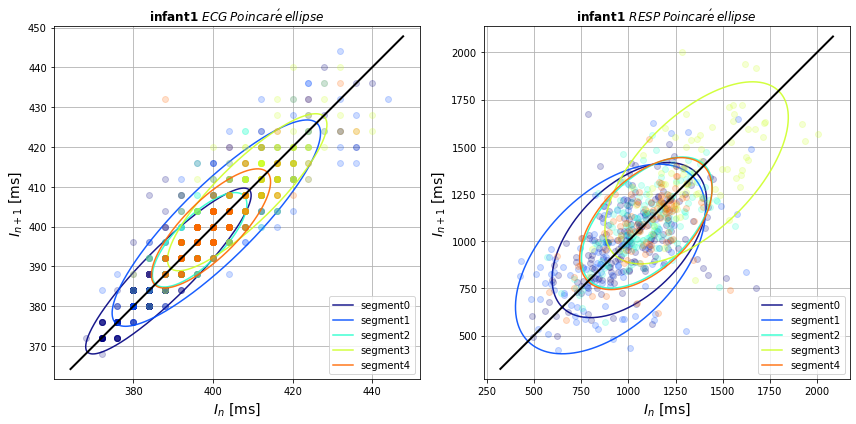

In [8]:
#%matplotlib qt
%matplotlib inline

# ellipse parameters
n_ell = 1000 # number of points in the ellipse contour
n_std = 2 # width of the ellipse (times standard deviation)
c_ = np.cos(np.linspace(0,2*np.pi,n_ell)) # cosine factors
s_ = np.sin(np.linspace(0,2*np.pi,n_ell)) # sine factors

key_subj = f"infant{file_index:d}"
print(f"Ellipse half-axes for: {key_subj:s}")
print("segment # | ECG diag. | ECG anti-diag. | ECG area | RESP diag. | RESP anti-diag. | RESP area")

cmap = plt.cm.jet
fig, ax = plt.subplots(1, 2, figsize=(12,6))
for i_seg, key_seg in enumerate(segments[key_subj]):
    #print(f"Processing: {key_subj:s} {key_seg:s}")
    file_ecg_intervals  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_intervals.txt")
    file_resp_intervals = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_intervals.txt")
    ecg_intervals = np.loadtxt(file_ecg_intervals)
    resp_intervals = np.loadtxt(file_resp_intervals)
    # convert seconds to milliseconds
    ecg_intervals *= 1000.
    resp_intervals *= 1000.
    print(f"\nECG intervals: N = {len(ecg_intervals):d}")
    print(f"ECG intervals: {ecg_intervals.mean():.2f} ({ecg_intervals.std():.2f}) ms")
    print(f"RESP intervals: N = {len(resp_intervals):d}")
    print(f"RESP intervals: {resp_intervals.mean():.2f} ({resp_intervals.std():.2f}) ms")
    
    col = i_seg*0.2 # segment index to number (0..1), number selects colour from scale
    mn_ecg, mx_ecg = ecg_intervals.min(), ecg_intervals.max()
    mn_resp, mx_resp = resp_intervals.min(), resp_intervals.max()
    mean_ecg = ecg_intervals.mean()
    mean_resp = resp_intervals.mean()
    s0_ecg, s1_ecg, v0_ecg, v1_ecg = poincare_plot(ecg_intervals, I_min=mn_ecg, I_max=mx_ecg)
    s0_resp, s1_resp, v0_resp, v1_resp = poincare_plot(resp_intervals, I_min=mn_resp, I_max=mx_resp)
    area_ecg = s0_ecg * s1_ecg
    area_resp = s0_resp * s1_resp
    print(f"{key_seg:s} {s0_ecg:.2f} {s1_ecg:.2f} {area_ecg:.2f} {s0_resp:.2f} {s1_resp:.2f} {area_resp:.2f}")
    
    # ECG Poincare ellipse x,y-coords.
    U_ecg = mean_ecg + n_std*s0_ecg*v0_ecg[0]*c_ + n_std*s1_ecg*v1_ecg[0]*s_
    V_ecg = mean_ecg + n_std*s0_ecg*v0_ecg[1]*c_ + n_std*s1_ecg*v1_ecg[1]*s_
    # RESP Poincare ellipse x,y-coords.
    U_resp = mean_resp + n_std*s0_resp*v0_resp[0]*c_ + n_std*s1_resp*v1_resp[0]*s_
    V_resp = mean_resp + n_std*s0_resp*v0_resp[1]*c_ + n_std*s1_resp*v1_resp[1]*s_
    # ellipses only
    ax[0].plot(U_ecg, V_ecg, '-k', color=cmap(col), alpha=0.9, label=key_seg)
    ax[1].plot(U_resp, V_resp, '-k', color=cmap(col), alpha=0.9, label=key_seg)
    #ax[0].plot(ecg_intervals, ecg_intervals, '-k', lw=2)
    #ax[1].plot(resp_intervals, resp_intervals, '-k', lw=2)
    # all data points
    ax[0].plot(ecg_intervals[:-1], ecg_intervals[1:], 'o', ms=6, color=cmap(col), alpha=0.2)
    #ax[0].plot(ecg_intervals, ecg_intervals, '-k', lw=2)
    ax[1].plot(resp_intervals[:-1], resp_intervals[1:], 'o', ms=6, color=cmap(col), alpha=0.2)
    #ax[1].plot(resp_intervals, resp_intervals, '-k', lw=2)
    #plt.plot(x_m, y_m, 'or', ms=8)
    #plt.plot([x_m, x_m+s0_hat*v0[0]], [y_m, y_m+s0_hat*v0[1]], '-b', lw=5)
    #plt.plot([x_m, x_m+s1_hat*v1[0]], [y_m, y_m+s1_hat*v1[1]], '-b', lw=5)

# diagonal plots
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), '-k', lw=2)
ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), '-k', lw=2)
ax[0].set_xlabel(r"$I_{n}$ [ms]", fontsize=14)
ax[0].set_ylabel(r"$I_{n+1}$ [ms]", fontsize=14)
ax[0].grid(True)
ax[0].axis('equal')
ax[1].set_xlabel(r"$I_{n}$ [ms]", fontsize=14)
ax[1].set_ylabel(r"$I_{n+1}$ [ms]", fontsize=14)
ax[1].grid(True)
ax[1].axis('equal')
ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[0].set_title(f"{key_subj:s}" + r" $ECG \: Poincar\'e \: ellipse$", fontweight="bold")
ax[1].set_title(f"{key_subj:s}" + r" $RESP \: Poincar\'e \: ellipse$", fontweight="bold")
plt.tight_layout()
plt.show()

Plot ellipses for all subject and segments.

In [ ]:
if False:
    %matplotlib qt

    # ellipse parameters
    n_ell = 1000 # number of points in the ellipse contour
    n_std = 2 # width of the ellipse (times standard deviation)
    c_ = np.cos(np.linspace(0,2*np.pi,n_ell)) # cosine factors
    s_ = np.sin(np.linspace(0,2*np.pi,n_ell)) # sine factors

    cmap = plt.cm.jet
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    for i_subj, key_subj in enumerate(segments):
        for i_seg, key_seg in enumerate(segments[key_subj]):
            file_index = i_subj+1
            #print(f"Processing: {key_subj:s} {key_seg:s}")
            file_ecg_intervals  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_intervals.txt")
            file_resp_intervals = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_intervals.txt")
            ecg_intervals = np.loadtxt(file_ecg_intervals)
            resp_intervals = np.loadtxt(file_resp_intervals)
            # convert seconds to milliseconds
            ecg_intervals *= 1000.
            resp_intervals *= 1000.

            col = i_subj*0.1 # subject index to number (0..1), number selects colour from scale
            mn_ecg, mx_ecg = ecg_intervals.min(), ecg_intervals.max()
            mn_resp, mx_resp = resp_intervals.min(), resp_intervals.max()
            mean_ecg = ecg_intervals.mean()
            mean_resp = resp_intervals.mean()
            s0_ecg, s1_ecg, v0_ecg, v1_ecg = poincare_plot(ecg_intervals, I_min=mn_ecg, I_max=mx_ecg)
            s0_resp, s1_resp, v0_resp, v1_resp = poincare_plot(resp_intervals, I_min=mn_resp, I_max=mx_resp)
            print(f"{key_subj:s} {key_seg:s} {s0_ecg:.3f} {s1_ecg:.3f} {s0_resp:.3f} {s1_resp:.3f}")

            # ECG Poincare ellipse x,y-coords.
            U_ecg = mean_ecg + n_std*s0_ecg*v0_ecg[0]*c_ + n_std*s1_ecg*v1_ecg[0]*s_
            V_ecg = mean_ecg + n_std*s0_ecg*v0_ecg[1]*c_ + n_std*s1_ecg*v1_ecg[1]*s_
            # RESP Poincare ellipse x,y-coords.
            U_resp = mean_resp + n_std*s0_resp*v0_resp[0]*c_ + n_std*s1_resp*v1_resp[0]*s_
            V_resp = mean_resp + n_std*s0_resp*v0_resp[1]*c_ + n_std*s1_resp*v1_resp[1]*s_
            # ellipses only
            if i_seg==0:
                ax[0].plot(U_ecg, V_ecg, '-k', color=cmap(col), alpha=0.5, label=key_subj)
                ax[1].plot(U_resp, V_resp, '-k', color=cmap(col), alpha=0.5, label=key_subj)
            else:
                ax[0].plot(U_ecg, V_ecg, '-k', color=cmap(col), alpha=0.5)
                ax[1].plot(U_resp, V_resp, '-k', color=cmap(col), alpha=0.5)
            #ax[0].plot(ecg_intervals, ecg_intervals, '-k', lw=2)
            #ax[1].plot(resp_intervals, resp_intervals, '-k', lw=2)
            # all data points
            #ax[0].plot(ecg_intervals[:-1], ecg_intervals[1:], 'o', ms=6, color=cmap(col), alpha=0.2)
            #ax[0].plot(ecg_intervals, ecg_intervals, '-k', lw=2)
            #ax[1].plot(resp_intervals[:-1], resp_intervals[1:], 'o', ms=6, color=cmap(col), alpha=0.2)
            #ax[1].plot(resp_intervals, resp_intervals, '-k', lw=2)
            #plt.plot(x_m, y_m, 'or', ms=8)
            #plt.plot([x_m, x_m+s0_hat*v0[0]], [y_m, y_m+s0_hat*v0[1]], '-b', lw=5)
            #plt.plot([x_m, x_m+s1_hat*v1[0]], [y_m, y_m+s1_hat*v1[1]], '-b', lw=5)

    # diagonal plots
    ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), '-k', lw=2)
    ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), '-k', lw=2)
    ax[0].set_xlabel(r"$I_{n}$ [ms]", fontsize=14)
    ax[0].set_ylabel(r"$I_{n+1}$ [ms]", fontsize=14)
    ax[0].grid(True)
    ax[0].axis('equal')
    ax[1].set_xlabel(r"$I_{n}$ [ms]", fontsize=14)
    ax[1].set_ylabel(r"$I_{n+1}$ [ms]", fontsize=14)
    ax[1].grid(True)
    ax[1].axis('equal')
    ax[0].legend(loc=4)
    ax[1].legend(loc=4)
    ax[0].set_title(r"$ECG \: Poincar\'e \: ellipses$", fontweight="bold")
    ax[1].set_title(r"$RESP \: Poincar\'e \: ellipses$", fontweight="bold")
    plt.tight_layout()
    plt.show()

# Interval statistics

In [9]:
filename_output = os.path.join(base_dir, "interval_stats.txt")
fp = open(filename_output, "w") # open file in write mode
for i_subj, key_subj in enumerate(segments):
    print(f"\n{key_subj:s}")
    fp.write(f"\n{key_subj:s}\n")
    for i_seg, key_seg in enumerate(segments[key_subj]):
        file_index = i_subj+1
        print(f"\n{key_seg:s}")
        fp.write(f"\n{key_seg:s}\n")
        file_ecg_intervals  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_intervals.txt")
        file_resp_intervals = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_intervals.txt")
        ecg_intervals = np.loadtxt(file_ecg_intervals)
        #print(ecg_intervals)
        #print("\nECG stats:")
        #interval_stats(ecg_intervals)
        mn_e = np.min(ecg_intervals)
        mx_e = np.max(ecg_intervals)
        mu_e = np.mean(ecg_intervals)
        sd_e = np.std(ecg_intervals)
        t5_e = np.percentile(ecg_intervals,95) # threshold for largest 5%
        print("\nECG R-R intervals (N, min, max, mean, std, 5pct): ")
        print(f"{len(ecg_intervals):d} {mn_e:.4f} {mx_e:.4f} {mu_e:.4f} {sd_e:.4f} {t5_e:.4f}")
        fp.write("\nECG R-R intervals (N, min, max, mean, std, 5pct):\n")
        fp.write(f"{len(ecg_intervals):d} {mn_e:.4f} {mx_e:.4f} {mu_e:.4f} {sd_e:.4f} {t5_e:.4f}\n")
        #print(f"{0.05*len(ecg_intervals):.1f}")
        idx_ecg_long = np.where(ecg_intervals > t5_e)[0]
        ecg_long = ecg_intervals[idx_ecg_long]
        print(f"Longest 5% ECG R-R intervals (N={len(idx_ecg_long):d}): ")
        fp.write(f"Longest 5% ECG R-R intervals (N={len(idx_ecg_long):d}):\n")
        for i, j in enumerate(idx_ecg_long):
            print(f"{i:d} {j:d} {ecg_long[i]:.4f}")
            fp.write(f"{i:d} {j:d} {ecg_long[i]:.4f}\n")
        
        resp_intervals = np.loadtxt(file_resp_intervals)
        #print(resp_intervals)
        #print("\nRESP stats:")
        #interval_stats(resp_intervals)
        mn_r = np.min(resp_intervals)
        mx_r = np.max(resp_intervals)
        mu_r = np.mean(resp_intervals)
        sd_r = np.std(resp_intervals)
        t5_r = np.percentile(resp_intervals,95) # threshold for largest 5%
        print("\nRESP peak-peak intervals (N, min, max, mean, std, 5pct): ")
        print(f"{len(resp_intervals):d} {mn_r:.4f} {mx_r:.4f} {mu_r:.4f} {sd_r:.4f} {t5_r:.4f}")
        fp.write("\nRESP peak-peak intervals (N, min, max, mean, std, 5pct):\n")
        fp.write(f"{len(resp_intervals):d} {mn_r:.4f} {mx_r:.4f} {mu_r:.4f} {sd_r:.4f} {t5_r:.4f}\n")
        #print(f"{0.05*len(resp_intervals):.1f}")
        idx_resp_long = np.where(resp_intervals > t5_r)[0]
        resp_long = resp_intervals[idx_resp_long]
        print(f"Longest 5% RESP peak-peak intervals (N={len(idx_resp_long):d}): ")
        fp.write(f"Longest 5% RESP peak-peak intervals (N={len(idx_resp_long):d}):\n")
        for i, j in enumerate(idx_resp_long):
            print(f"{i:d} {j:d} {resp_long[i]:.4f}")
            fp.write(f"{i:d} {j:d} {resp_long[i]:.4f}\n")
fp.close()
print(f"\nResults written to file: {filename_output:s}")


infant1

segment0

ECG R-R intervals (N, min, max, mean, std, 5pct): 
513 0.3680 0.4400 0.3888 0.0104 0.4080
Longest 5% ECG R-R intervals (N=20): 
0 48 0.4120
1 49 0.4120
2 122 0.4160
3 123 0.4200
4 124 0.4120
5 127 0.4120
6 128 0.4200
7 129 0.4120
8 209 0.4120
9 212 0.4160
10 213 0.4120
11 214 0.4240
12 215 0.4280
13 216 0.4280
14 217 0.4400
15 218 0.4360
16 219 0.4360
17 220 0.4200
18 221 0.4200
19 222 0.4120

RESP peak-peak intervals (N, min, max, mean, std, 5pct): 
198 0.4900 1.6740 1.0056 0.2043 1.3960
Longest 5% RESP peak-peak intervals (N=9): 
0 8 1.4040
1 42 1.4160
2 48 1.4200
3 66 1.4500
4 71 1.4220
5 80 1.3980
6 113 1.4320
7 138 1.5160
8 171 1.6740

segment1

ECG R-R intervals (N, min, max, mean, std, 5pct): 
254 0.3720 0.4440 0.4009 0.0130 0.4240
Longest 5% ECG R-R intervals (N=12): 
0 43 0.4320
1 45 0.4320
2 111 0.4360
3 166 0.4280
4 167 0.4360
5 224 0.4320
6 225 0.4440
7 226 0.4320
8 227 0.4320
9 230 0.4360
10 231 0.4280
11 242 0.4320

RESP peak-peak intervals (N, min, ma

## Show lowest ECG and RESP intervals (single segment)

### Select a subject and segment index

In [10]:
file_index = 1
segment_index = 1
print(f"file_index: {file_index:d}\nsegment_index: {segment_index:d}")

file_index: 1
segment_index: 1


## Continuous heart and respiratory rate

Estimate heart rate and breathing frequency as continuous variables. Each peak-to-peak interval defines an instantaneous frequency, located at the mid-point of the interval, and the continuous rates are obtained via interpolation.

ECG sampling frequency:  250.0  Hz
ECG sampling interval dt =  0.004  sec.
RESP sampling frequency:  500.0  Hz
RESP sampling interval dt =  0.002  sec.
Percentage of ECG rate below 100.0 bpm: 0.0 %
Percentage of ECG rate above 160.0 bpm: 0.4 %
Percentage of RESP rate below 40.0 per min.: 5.8 %
Percentage of RESP rate above 60.0 per min.: 62.6 %


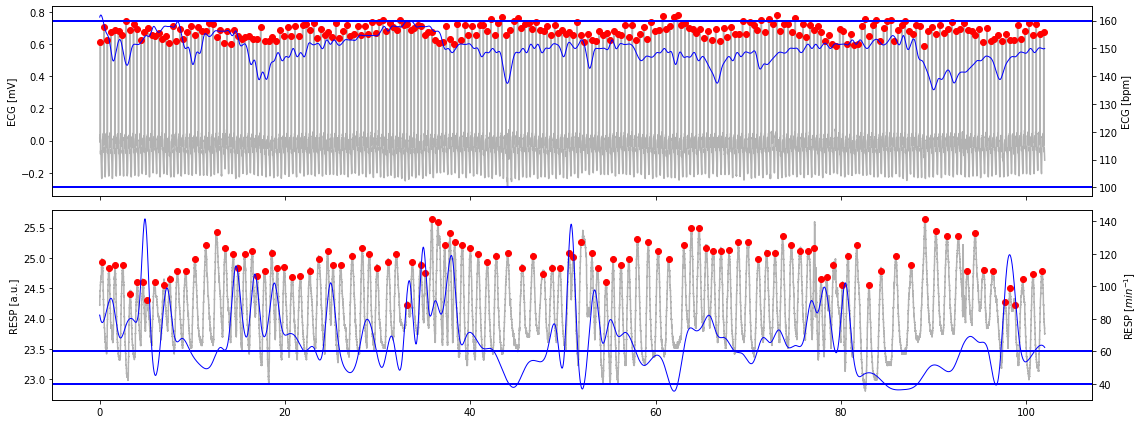

In [11]:
#%matplotlib qt
%matplotlib inline

key_subj = f"infant{file_index:d}"
key_seg = f"segment{segment_index:d}"

# load exported data
file_time_ecg = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_time.txt")
file_time_resp = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_time.txt")
time_ecg = np.loadtxt(file_time_ecg)
time_resp = np.loadtxt(file_time_resp)

file_ecg  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg.txt")
file_resp = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp.txt")
x_ecg = np.loadtxt(file_ecg)
x_resp = np.loadtxt(file_resp)

file_ecg_filt  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_filt.txt")
file_resp_filt = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_filt.txt")
x_ecg_filt = np.loadtxt(file_ecg_filt)
x_resp_filt = np.loadtxt(file_resp_filt)

file_locmax_ecg  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_locmax_ecg.txt")
file_locmax_resp = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_locmax_resp.txt")
locmax_ecg = np.loadtxt(file_locmax_ecg).astype('int')
locmax_resp = np.loadtxt(file_locmax_resp).astype('int')

file_ecg_intervals  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_intervals.txt")
file_resp_intervals = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_intervals.txt")
ecg_intervals = np.loadtxt(file_ecg_intervals)
resp_intervals = np.loadtxt(file_resp_intervals)

dt_ecg = time_ecg[1]-time_ecg[0]
dt_resp = time_resp[1]-time_resp[0]
fs_ecg = 1/dt_ecg # ECG sampling rate in Hz
fs_resp = 1/dt_resp # RESP sampling rate in Hz
print("ECG sampling frequency: ", fs_ecg, " Hz")
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling frequency: ", fs_resp, " Hz")
print("RESP sampling interval dt = ", dt_resp, " sec.")

# interpolate ECG and RESP peak-to-peak intervals
t_mid_ecg = dt_ecg*(locmax_ecg[1:] + locmax_ecg[:-1])/2.0
t_mid_resp = dt_resp*(locmax_resp[1:] + locmax_resp[:-1])/2.0
#ecg_int_mid = (ecg_intervals[1:] - ecg_intervals[:-1])/2.0
#resp_int_mid = (resp_intervals[1:] - resp_intervals[:-1])/2.0
ecg_int_mid = 60./ecg_intervals
resp_int_mid = 60./resp_intervals

# avoid edge effects, insert first and last time stamps
t_mid_ecg = np.insert(t_mid_ecg, 0, time_ecg[0])
t_mid_ecg = np.insert(t_mid_ecg, t_mid_ecg.shape[0], time_ecg[-1])
t_mid_resp = np.insert(t_mid_resp, 0, time_resp[0])
t_mid_resp = np.insert(t_mid_resp, t_mid_resp.shape[0], time_resp[-1])
# repeat first and last ECG/RESP frequency
ecg_int_mid = np.insert(ecg_int_mid, 0, ecg_int_mid[0])
ecg_int_mid = np.insert(ecg_int_mid, ecg_int_mid.shape[0], ecg_int_mid[-1])
resp_int_mid = np.insert(resp_int_mid, 0, resp_int_mid[0])
resp_int_mid = np.insert(resp_int_mid, resp_int_mid.shape[0], resp_int_mid[-1])

#fig, ax = plt.subplots(2, 1, figsize=(16,6))
#ax[0].plot(t_mid_ecg, ecg_intervals, '-ok', lw=2)
#ax[1].plot(t_mid_resp, resp_intervals, '-ok', lw=2)
#ax[0].plot(ecg_intervals, '-ok', lw=2)
#ax[1].plot(resp_intervals, '-ok', lw=2)
#plt.show()

#print(t_mid_ecg.shape, t_mid_resp.shape, ecg_int_mid.shape, resp_int_mid.shape)

ipmode='cubic'  # 'linear'
fip_ecg = interp1d(t_mid_ecg, ecg_int_mid, kind=ipmode, fill_value='extrapolate')
fip_resp = interp1d(t_mid_resp, resp_int_mid, kind=ipmode, fill_value='extrapolate')
ecg_rate = fip_ecg(time_ecg)
resp_rate = fip_resp(time_resp)
ksize = 3
ecg_rate = medfilt(ecg_rate,kernel_size=ksize)
resp_rate = medfilt(resp_rate,kernel_size=ksize)
#print(ecg_rate)

# add norm boundaries, values from: [REF.]
ecg_rate_norm_lo = 100
ecg_rate_norm_hi = 160
resp_rate_norm_lo = 40
resp_rate_norm_hi = 60
# percentages outside the norm ranges
pct_ecg_ltref = 100.*len(np.where(ecg_rate < ecg_rate_norm_lo)[0])/len(ecg_rate)
pct_ecg_gtref = 100.*len(np.where(ecg_rate > ecg_rate_norm_hi)[0])/len(ecg_rate)
pct_resp_ltref = 100.*len(np.where(resp_rate < resp_rate_norm_lo)[0])/len(resp_rate)
pct_resp_gtref = 100.*len(np.where(resp_rate > resp_rate_norm_hi)[0])/len(resp_rate)
print(f"Percentage of ECG rate below {ecg_rate_norm_lo:.1f} bpm: {pct_ecg_ltref:.1f} %")
print(f"Percentage of ECG rate above {ecg_rate_norm_hi:.1f} bpm: {pct_ecg_gtref:.1f} %")
print(f"Percentage of RESP rate below {resp_rate_norm_lo:.1f} per min.: {pct_resp_ltref:.1f} %")
print(f"Percentage of RESP rate above {resp_rate_norm_hi:.1f} per min.: {pct_resp_gtref:.1f} %")

#'''
fig, ax = plt.subplots(2, 1, figsize=(16,6), sharex=True)

ax[0].plot(time_ecg, x_ecg, '-k', alpha=0.3)
ax[0].plot(time_ecg[locmax_ecg], x_ecg[locmax_ecg], 'or', ms=6)
ax[0].set_ylabel("ECG [mV]")
ax0c = ax[0].twinx()
ax0c.plot(time_ecg, ecg_rate, '-b', lw=1)
ax0c.axhline(y=ecg_rate_norm_lo, color='b', lw=2)
ax0c.axhline(y=ecg_rate_norm_hi, color='b', lw=2)
ax0c.set_ylabel("ECG [bpm]")
#ax1c.set_ylabel(r"RESP [$min^{-1}$]")

ax[1].plot(time_resp, x_resp, '-k', alpha=0.3)
ax[1].plot(time_resp[locmax_resp], x_resp[locmax_resp], 'or', ms=6)
ax[1].set_ylabel("RESP [a.u.]")
ax1c = ax[1].twinx()
ax1c.plot(time_resp, resp_rate, '-b', lw=1)
ax1c.axhline(y=resp_rate_norm_lo, color='b', lw=2)
ax1c.axhline(y=resp_rate_norm_hi, color='b', lw=2)
ax1c.set_ylabel(r"RESP [$min^{-1}$]")

plt.tight_layout()
plt.show()
#'''

## Peak-to-peak interval histograms

Plot ECG/RESP peak-to-peak interval distributions.

ECG intervals: min=0.372, max=0.444 sec
RESP intervals: min=0.424, max=1.648 sec


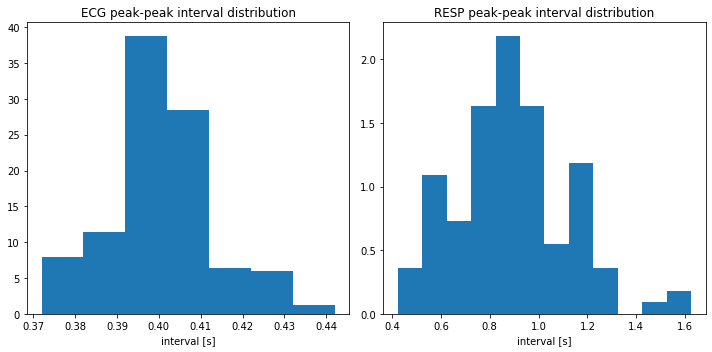

In [12]:
key_subj = f"infant{file_index:d}"
key_seg = f"segment{segment_index:d}"

# load exported data
file_time_ecg = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_time.txt")
file_time_resp = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_time.txt")
time_ecg = np.loadtxt(file_time_ecg)
time_resp = np.loadtxt(file_time_resp)

file_ecg_intervals  = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_ecg_intervals.txt")
file_resp_intervals = os.path.join(export_dir, f"{key_subj:s}_{key_seg:s}_resp_intervals.txt")
ecg_intervals = np.loadtxt(file_ecg_intervals)
resp_intervals = np.loadtxt(file_resp_intervals)
#print(ecg_intervals)
#print(resp_intervals)

print(f"ECG intervals: min={ecg_intervals.min():.3f}, max={ecg_intervals.max():.3f} sec")
print(f"RESP intervals: min={resp_intervals.min():.3f}, max={resp_intervals.max():.3f} sec")

dt_ecg = time_ecg[1]-time_ecg[0]
dt_resp = time_resp[1]-time_resp[0]
fs_ecg = 1/dt_ecg # ECG sampling rate in Hz
fs_resp = 1/dt_resp # RESP sampling rate in Hz
#print("ECG sampling frequency: ", fs_ecg, " Hz")
#print("ECG sampling interval dt = ", dt_ecg, " sec.")
#print("RESP sampling frequency: ", fs_resp, " Hz")
#print("RESP sampling interval dt = ", dt_resp, " sec.")

bin_width_ecg = 0.01 # sec
bin_width_resp = 0.1 # sec
bins_ecg = np.arange(ecg_intervals.min(), ecg_intervals.max(), bin_width_ecg)
bins_resp = np.arange(resp_intervals.min(), resp_intervals.max(), bin_width_resp)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(ecg_intervals, bins=bins_ecg, density=True)
ax[0].set_xlabel("interval [s]")
ax[0].set_title("ECG peak-peak interval distribution")
ax[1].hist(resp_intervals, bins=bins_resp, density=True)
ax[1].set_xlabel("interval [s]")
ax[1].set_title("RESP peak-peak interval distribution")
plt.tight_layout()
plt.show()

## Analyze long cardiac and respiratory intervals

- Longest intervals may contain bradycardias / bradypneas
- Define percentile cutoff to look for bradycardias and hypopneas / apneas

In [13]:
thr_pct_brady = 5 # cut-off percentile for bradycardias [%]
thr_pct_hypo = 5 # cut-off percentile for hypopneas [%]
thr_brady = np.percentile(ecg_intervals,100-thr_pct_brady)
thr_hypo = np.percentile(resp_intervals,100-thr_pct_hypo)
print(f"Bradycardia threshold: {thr_brady:.3f} sec")
print(f"Hypopnea threshold: {thr_hypo:.3f} sec")
ecg_large_intervals = ecg_intervals[ecg_intervals > thr_brady]
resp_large_intervals = resp_intervals[resp_intervals > thr_hypo]
ecg_brady = np.where(ecg_intervals > thr_brady)[0] # large ECG interval onsets
resp_hypo = np.where(resp_intervals > thr_hypo)[0] # large RESP interval onsets
loc_brady = locmax_ecg[ecg_brady]
loc_hypo = locmax_resp[resp_hypo]

Bradycardia threshold: 0.424 sec
Hypopnea threshold: 1.319 sec


Print longest intervals:

In [14]:
print(f"\nLargest {thr_pct_brady:.1f}% ECG R-R intervals [sec]:")
for i, v in enumerate(ecg_large_intervals): 
    print(f"\tLong interval #{i:d} starts at t={time_ecg[loc_brady[i]]:.2f}, duration: {v:.2f}")
print(f"\nLargest {thr_pct_hypo:.1f}% RESP peak-peak intervals [sec]:")
for i, v in enumerate(resp_large_intervals): 
    print(f"\t Long interval #{i:d} starts at t={time_resp[loc_hypo[i]]:.2f}, duration: {v:.2f}")


Largest 5.0% ECG R-R intervals [sec]:
	Long interval #0 starts at t=16.94, duration: 0.43
	Long interval #1 starts at t=17.80, duration: 0.43
	Long interval #2 starts at t=43.85, duration: 0.44
	Long interval #3 starts at t=66.05, duration: 0.43
	Long interval #4 starts at t=66.48, duration: 0.44
	Long interval #5 starts at t=89.38, duration: 0.43
	Long interval #6 starts at t=89.81, duration: 0.44
	Long interval #7 starts at t=90.26, duration: 0.43
	Long interval #8 starts at t=90.69, duration: 0.43
	Long interval #9 starts at t=91.97, duration: 0.44
	Long interval #10 starts at t=92.40, duration: 0.43
	Long interval #11 starts at t=96.99, duration: 0.43

Largest 5.0% RESP peak-peak intervals [sec]:
	 Long interval #0 starts at t=44.03, duration: 1.57
	 Long interval #1 starts at t=61.40, duration: 1.63
	 Long interval #2 starts at t=81.71, duration: 1.32
	 Long interval #3 starts at t=84.35, duration: 1.58
	 Long interval #4 starts at t=85.93, duration: 1.65
	 Long interval #5 start

Plot ECG/RESP waveforms
- peaks marked by red dots
- onsets of hypo intervals marked by blue diamonds (hypo: lower percentile of ECG/RESP interval)

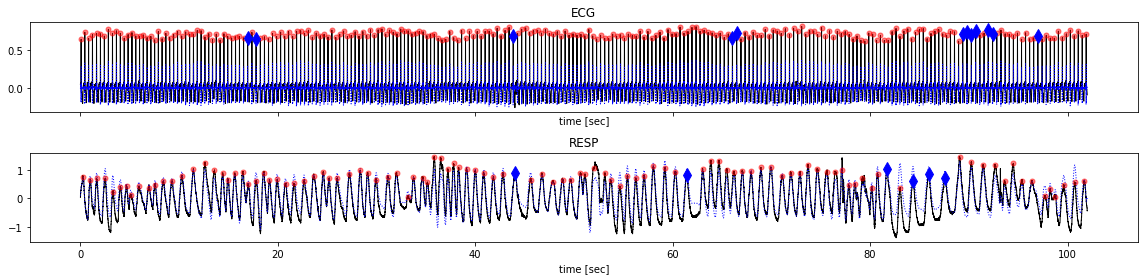

In [15]:
#%matplotlib qt
%matplotlib inline

fig5, ax = plt.subplots(2, 1, figsize=(16,4), sharex=True)

x_ecg_demean = x_ecg-x_ecg.mean()
ax[0].plot(time_ecg, x_ecg_demean, '-k', lw=1) # original ECG signal (black line)
ax[0].plot(time_ecg, x_ecg_filt, ':b', lw=1) # band-pass filtered ECG (blue-dotted line)
# local maxima as red dots on unfiltered ECG:
ax[0].plot(time_ecg[locmax_ecg], x_ecg_demean[locmax_ecg], 'or', ms=5, alpha=0.5)
# local maxima as red dots on filtered ECG:
#ax[0].plot(time_ecg[locmax_ecg], x_ecg_filt[locmax_ecg], 'or', ms=5, alpha=0.5)
# bradycardia onsets:
ax[0].plot(time_ecg[loc_brady], x_ecg_demean[loc_brady], 'db', ms=10)
ax[0].set_xlabel("time [sec]")
ax[0].set_title("ECG")

x_resp_demean = x_resp-x_resp.mean()
ax[1].plot(time_resp, x_resp-x_resp.mean(), '-k', lw=1) # original RESP signal (black line)
ax[1].plot(time_resp, x_resp_filt, ':b', lw=1) # band-pass filtered RESP (blue-dotted line)
# local maxima as red dots on unfiltered RESP:
ax[1].plot(time_resp[locmax_resp], x_resp_demean[locmax_resp], 'or', ms=5, alpha=0.5)
# local maxima as red dots on filtered RESP:
#ax[1].plot(time_resp[locmax_resp], x_resp_filt[locmax_resp], 'or', ms=5, alpha=0.5)
# bradycardia onsets:
ax[1].plot(time_resp[loc_hypo], x_resp_demean[loc_hypo], 'db', ms=10) # local maxima at hypopnea time points
ax[1].set_xlabel("time [sec]")
ax[1].set_title("RESP")

plt.tight_layout()
plt.show()

Compare local maxima on unfiltered and filtered data:

#%matplotlib qt

fig4, ax = plt.subplots(2, 1, figsize=(16,4), sharex=True)

x_ecg_demean = x_ecg-x_ecg.mean()
ax[0].plot(time_ecg, x_ecg_demean, '-k', lw=1) # original ECG signal (black line)
ax[0].plot(time_ecg, x_ecg_filt, ':b', lw=1) # band-pass filtered ECG (blue-dotted line)
ax[0].plot(time_ecg[locmax_ecg], x_ecg_demean[locmax_ecg], 'or', ms=5) # local maxima as red dots on unfiltered ECG
#ax[0].plot(time_ecg[locmax_ecg], x_ecg_filt[locmax_ecg], 'or', ms=5) # local maxima as red dots on filtered ECG
ax[0].set_xlabel("time [sec]")
ax[0].set_title("ECG")

x_resp_demean = x_resp-x_resp.mean()
ax[1].plot(time_resp, x_resp-x_resp.mean(), '-k', lw=1) # original RESP signal (black line)
ax[1].plot(time_resp, x_resp_filt, ':b', lw=1) # band-pass filtered RESP (blue-dotted line) 
ax[1].plot(time_resp[locmax_resp], x_resp_demean[locmax_resp], 'or', ms=5) # local maxima as red dots on unfiltered RESP
ax[1].plot(time_resp[locmax_resp], x_resp_filt[locmax_resp], 'or', ms=5) # local maxima as red dots on filtered RESP
for i,p in enumerate(locmax_resp):
    ax[1].plot([time_resp[p],time_resp[p]], [x_resp_demean[p]+0.1,x_resp_demean[p]+0.2], '-r', lw=1)
ax[1].set_xlabel("time [sec]")
ax[1].set_title("RESP")

plt.tight_layout()
plt.show()